<a href="https://colab.research.google.com/github/FelixSchmid/GANs_MNIST/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST

## Loading data

In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [0]:
(train_data,_),(test_data,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
data = np.concatenate((train_data,test_data),axis=0)

In [0]:
data.shape

(70000, 28, 28)

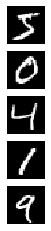

In [0]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [0]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [0]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [0]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


### Model parameters

In [0]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [0]:
from tensorflow.keras.optimizers import Adam

# Some empirically set values. 
# It might well be worth experimenting with newer optimizers / settings
optimizer = Adam(lr=2e-4, beta_1=0.5)

### Generator

In [0]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [0]:
### Define the generator!
#########################

# The generator always gets a noise vector as input
noise_input = Input(shape = (Z_DIM,))

# Define the first layer of the fully connected network
g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)
g_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_1)

# Repeat the process two more times!
g_layer_2 = Dense(GENERATOR_L2_DIM)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)

g_layer_3 = Dense(GENERATOR_L3_DIM)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Use that one as an activation for the final fully connected layer!
g_output_layer = Dense(784, activation='tanh')(g_layer_3_nonlin)

# Please instantiate the model!
generator = Model(inputs=noise_input, outputs=g_output_layer)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0     

### Discriminator

In [0]:
### Define the discriminator!
#############################

image_input = Input(shape=(data.shape[1],))

d_layer_1 = Dense(DISCRIMINATOR_L1_DIM)(image_input)
d_layer_1_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_1)

d_layer_2 = Dense(DISCRIMINATOR_L1_DIM)(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(d_layer_2)  

d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)

# Please instantiate the model!
discriminator = Model(inputs=image_input, outputs=d_output_layer)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 665,089
Trainable params: 665,089
Non-trainable params: 0
_____________________________________________________

### Joint model

In [0]:
### Define the GAN itself!
##########################

# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

gan_input = Input(shape=(Z_DIM,))
# Use the generator as a function on the input!
generated_image = generator(gan_input)
# Use the discriminator as a function on the fake images!
gan_output = discriminator(generated_image)

# Instantiate the joint model, appropriate input and output!
joint_model = Model(inputs=gan_input, outputs=gan_output)
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [0]:
joint_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 784)               1486352   
_________________________________________________________________
model_1 (Model)              (None, 1)                 665089    
Total params: 2,151,441
Trainable params: 1,486,352
Non-trainable params: 665,089
_________________________________________________________________


## Helper functions for visualization

In [0]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)
    
    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

  0%|          | 0/350 [00:00<?, ?it/s]

100%|██████████| 350/350 [00:33<00:00, 11.11it/s]


Epoch number: 0 discriminator_loss: 0.607962304183415 generator_loss: 1.0480761696611132


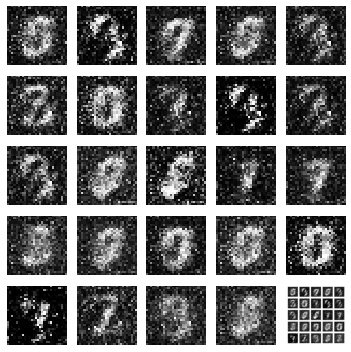

100%|██████████| 350/350 [00:32<00:00, 10.80it/s]


Epoch number: 1 discriminator_loss: 0.6123573756217957 generator_loss: 1.2498356366157533


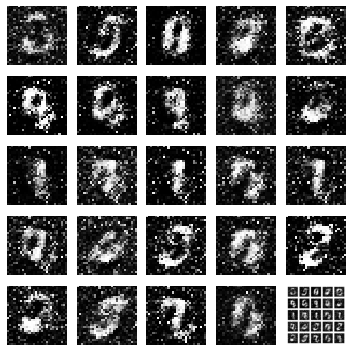

100%|██████████| 350/350 [00:32<00:00, 10.87it/s]


Epoch number: 2 discriminator_loss: 0.5796998241969518 generator_loss: 1.3723586181231908


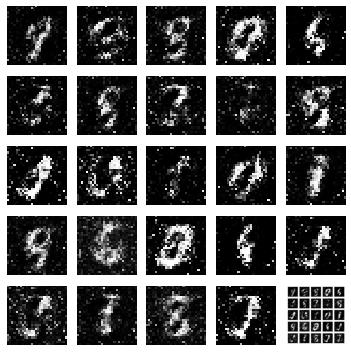

100%|██████████| 350/350 [00:32<00:00, 10.69it/s]


Epoch number: 3 discriminator_loss: 0.5397014938082014 generator_loss: 1.4769756664548601


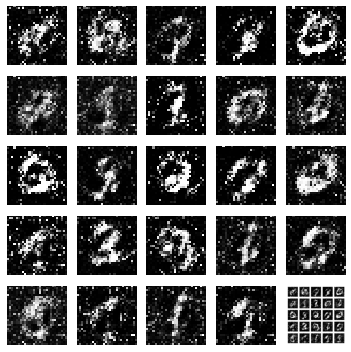

100%|██████████| 350/350 [00:32<00:00, 11.00it/s]


Epoch number: 4 discriminator_loss: 0.5504731959104538 generator_loss: 1.4274016196387154


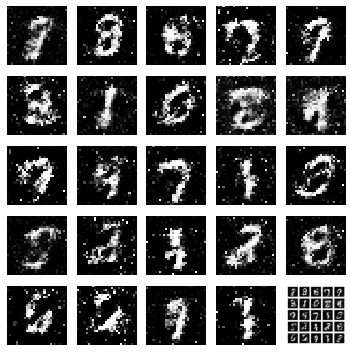

100%|██████████| 350/350 [00:32<00:00, 10.71it/s]


Epoch number: 5 discriminator_loss: 0.5921155658790044 generator_loss: 1.256631613458906


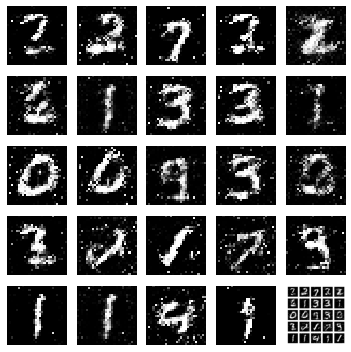

100%|██████████| 350/350 [00:32<00:00, 10.72it/s]


Epoch number: 6 discriminator_loss: 0.6102535215445927 generator_loss: 1.1726674818992615


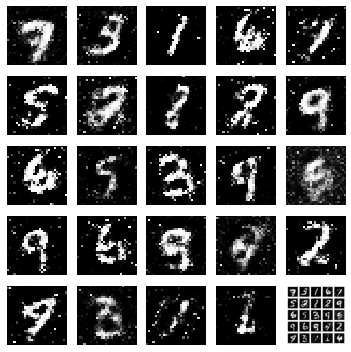

100%|██████████| 350/350 [00:32<00:00, 10.75it/s]


Epoch number: 7 discriminator_loss: 0.6166037942681993 generator_loss: 1.1383314377920968


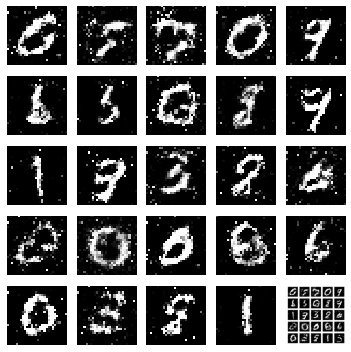

100%|██████████| 350/350 [00:32<00:00, 10.66it/s]


Epoch number: 8 discriminator_loss: 0.62019612295287 generator_loss: 1.1457304586683001


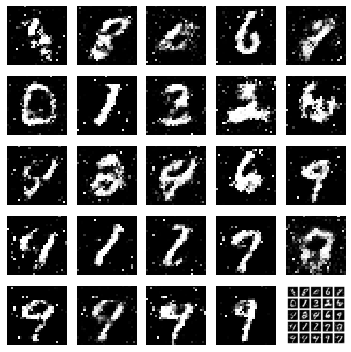

100%|██████████| 350/350 [00:32<00:00, 10.68it/s]


Epoch number: 9 discriminator_loss: 0.6322419156347002 generator_loss: 1.109917539358139


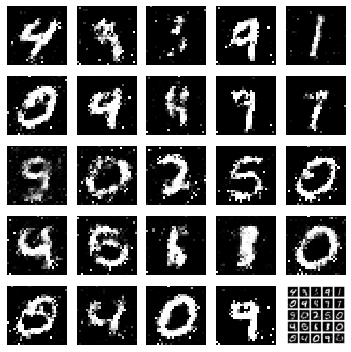

100%|██████████| 350/350 [00:32<00:00, 10.65it/s]


Epoch number: 10 discriminator_loss: 0.6307649852548327 generator_loss: 1.1054564213752747


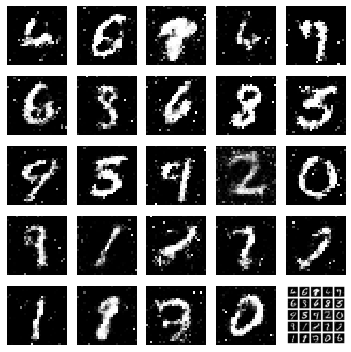

100%|██████████| 350/350 [00:32<00:00, 10.68it/s]


Epoch number: 11 discriminator_loss: 0.6330455735751561 generator_loss: 1.107661177771432


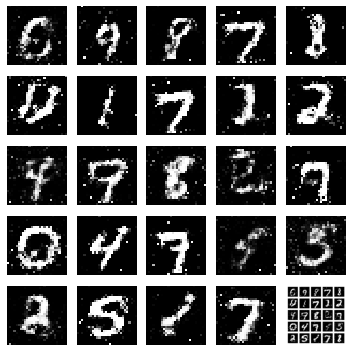

100%|██████████| 350/350 [00:32<00:00, 10.81it/s]


Epoch number: 12 discriminator_loss: 0.6342298945358821 generator_loss: 1.1029548702921186


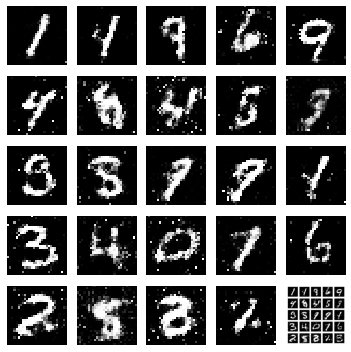

100%|██████████| 350/350 [00:33<00:00,  9.88it/s]


Epoch number: 13 discriminator_loss: 0.6378589459827968 generator_loss: 1.0988673143727439


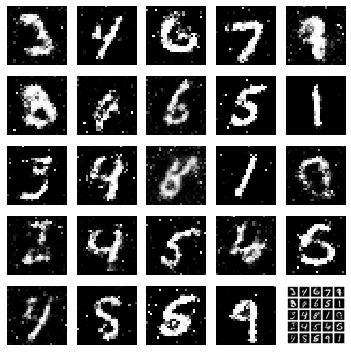

100%|██████████| 350/350 [00:34<00:00, 10.19it/s]


Epoch number: 14 discriminator_loss: 0.644340581383024 generator_loss: 1.0861366898672922


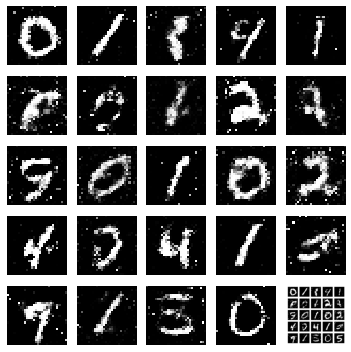

100%|██████████| 350/350 [00:35<00:00,  9.80it/s]


Epoch number: 15 discriminator_loss: 0.647184351342065 generator_loss: 1.077547470501491


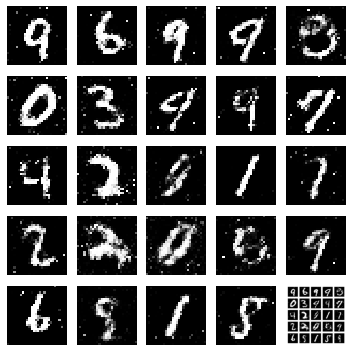

100%|██████████| 350/350 [00:35<00:00,  9.61it/s]


Epoch number: 16 discriminator_loss: 0.651769061599459 generator_loss: 1.0658442017010281


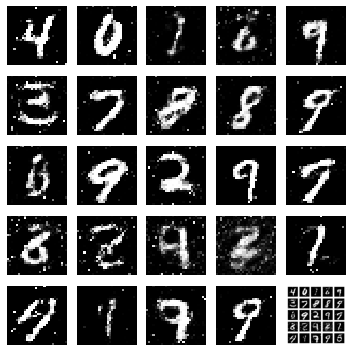

100%|██████████| 350/350 [00:36<00:00,  9.70it/s]


Epoch number: 17 discriminator_loss: 0.6514602868897574 generator_loss: 1.067248842716217


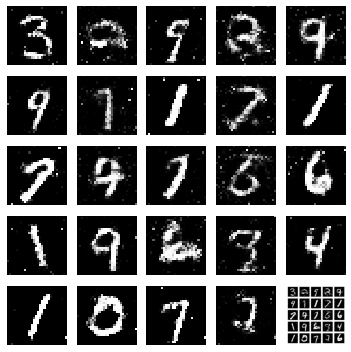

100%|██████████| 350/350 [00:34<00:00, 10.15it/s]


Epoch number: 18 discriminator_loss: 0.6524592568193163 generator_loss: 1.0642029522146497


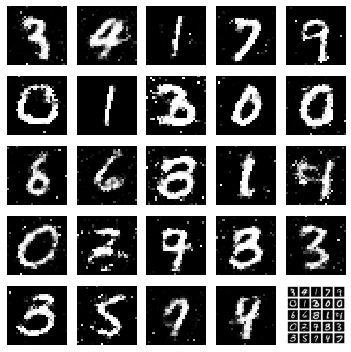

100%|██████████| 350/350 [00:35<00:00,  9.94it/s]


Epoch number: 19 discriminator_loss: 0.6549067798682622 generator_loss: 1.061316909108843


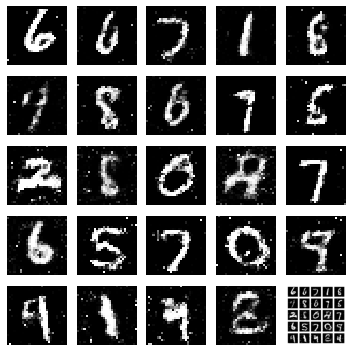

100%|██████████| 350/350 [00:35<00:00,  9.97it/s]


Epoch number: 20 discriminator_loss: 0.6568490214007241 generator_loss: 1.052270120893206


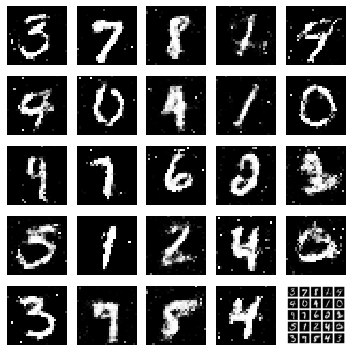

100%|██████████| 350/350 [00:34<00:00, 10.13it/s]


Epoch number: 21 discriminator_loss: 0.6566023341247014 generator_loss: 1.049579908336912


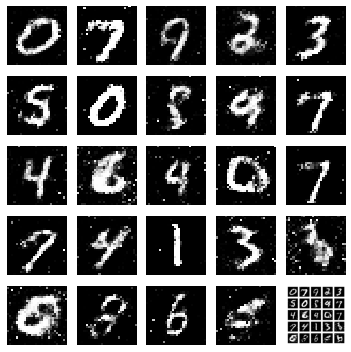

100%|██████████| 350/350 [00:34<00:00, 10.03it/s]


Epoch number: 22 discriminator_loss: 0.6585625830718449 generator_loss: 1.0497326690810067


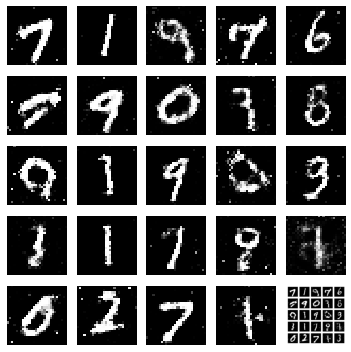

100%|██████████| 350/350 [00:34<00:00, 10.11it/s]


Epoch number: 23 discriminator_loss: 0.6595846925462995 generator_loss: 1.0483482699734823


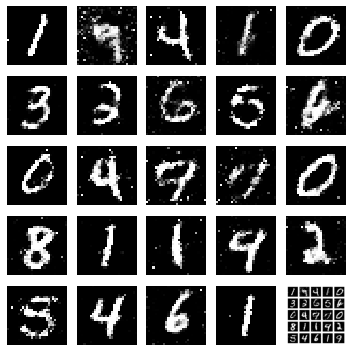

100%|██████████| 350/350 [00:34<00:00, 10.52it/s]


Epoch number: 24 discriminator_loss: 0.6569672855309078 generator_loss: 1.046687833070755


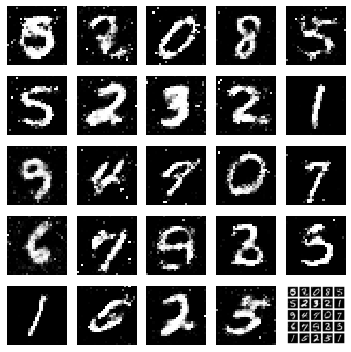

100%|██████████| 350/350 [00:33<00:00, 10.33it/s]


Epoch number: 25 discriminator_loss: 0.6592414452348436 generator_loss: 1.0434884411948069


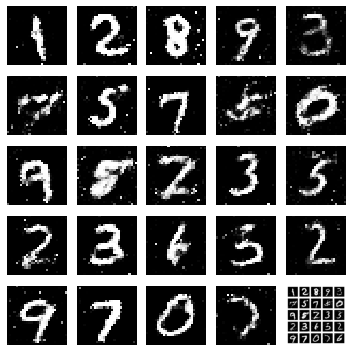

100%|██████████| 350/350 [00:34<00:00, 10.62it/s]


Epoch number: 26 discriminator_loss: 0.6583268490859441 generator_loss: 1.0503354578358786


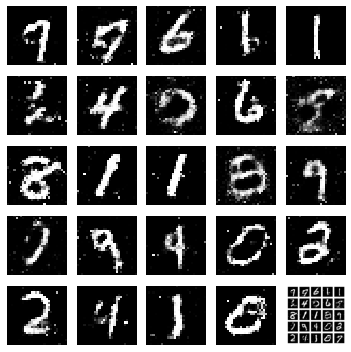

100%|██████████| 350/350 [00:33<00:00, 10.59it/s]


Epoch number: 27 discriminator_loss: 0.6590533443859645 generator_loss: 1.0398635739939552


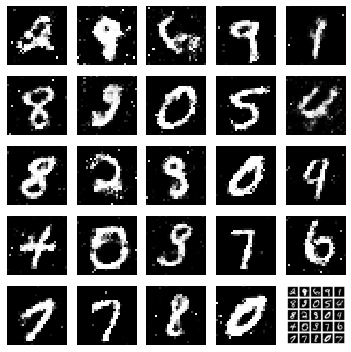

100%|██████████| 350/350 [00:33<00:00, 10.54it/s]


Epoch number: 28 discriminator_loss: 0.6610995083195823 generator_loss: 1.0387303406851631


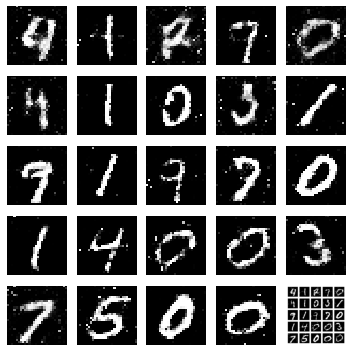

100%|██████████| 350/350 [00:34<00:00,  9.93it/s]


Epoch number: 29 discriminator_loss: 0.6606663375241416 generator_loss: 1.0387831442696707


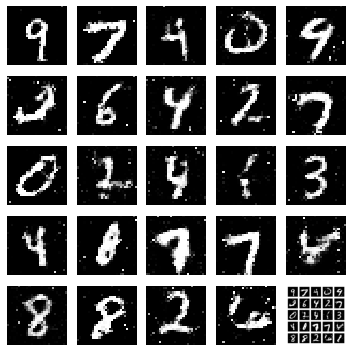

In [0]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0
    
    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!
        real_images = data[np.random.randint(low=0,
                                             high=data.shape[0],
                                             size=HALF_BATCH)]
        
        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0,1, size=(HALF_BATCH,Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!
        generated_images = generator.predict(input_noise)
        
        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones(HALF_BATCH)*0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros(HALF_BATCH)

        
        ### We do the actual training!
        
        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)
        
        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)
        
        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss
        
        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model
        
        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0,1, [BATCH_SIZE, Z_DIM])
        
        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones 
        convincing_y = np.ones(BATCH_SIZE) 
        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss
        
    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, \
          "generator_loss:", epoch_generator_loss / BATCH_NUM)
    
    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)
    
    #Save model - optional
    #generator.save("generator.h5")
    
    #Save images
    get_example_images(epoch_num)
    
    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

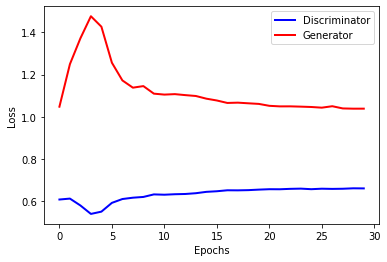

In [0]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
